In [1]:
import numpy as np
import plotly.graph_objects as go
import mne
import configparser
from main_meg_qc import sanity_check
from initial_meg_qc import get_all_config_params, sanity_check, initial_processing


/Users/jenya/opt/anaconda3/envs/mne_new/lib/python3.9/site-packages/ancpbids/pybids_compat.py:14: UserWarning: Development of the BIDSLayout interface will continue in the pybids project.
  warnings.warn('Development of the BIDSLayout interface will continue in the pybids project.')


In [2]:
config = configparser.ConfigParser()
config.read('settings.ini')
data_file='/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003483/sub-009/ses-1/meg/sub-009_ses-1_task-deduction_run-1_meg.fif'


all_qc_params = get_all_config_params('settings.ini')
dict_of_dfs_epoch, epochs_mg, channels, raw_filtered, raw_filtered_resampled, raw_cropped, raw, active_shielding_used = initial_processing(default_settings=all_qc_params['default'], filtering_settings=all_qc_params['Filtering'], epoching_params=all_qc_params['Epoching'], data_file=data_file)

m_or_g_chosen = ['mags', 'grads']

m_or_g_chosen = sanity_check(m_or_g_chosen, channels)

if len(m_or_g_chosen) == 0: 
    raise ValueError('No channels to analyze. Check presence of mags and grads in your data set and parameter do_for in settings.')


default_section = config['DEFAULT']
tmin = default_section['data_crop_tmin']
tmax = default_section['data_crop_tmax']

if not tmin: 
    tmin = 0
else:
    tmin=float(tmin)
if not tmax: 
    tmax = raw.times[-1] 
else:
    tmax=float(tmax)

duration = tmax-tmin

print('Data duration is ', duration, ' seconds')

Opening raw data file /Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003483/sub-009/ses-1/meg/sub-009_ses-1_task-deduction_run-1_meg.fif...
    Range : 60000 ... 1255999 =     60.000 ...  1255.999 secs
Ready.
Reading 0 ... 60000  =      0.000 ...    60.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 100.00 Hz: -6.02, -6.02 dB

18 events found
Event IDs: [  2   4   8 100]
18 events found
Event IDs: [  2   4   8 100]
Stimulus channels detected: ['STI101', 'STI201', 'STI301']
9 events found
Event IDs: [2 4 8]
Trigger channel has a non-zero initial value of 3840 (consider using initial_event=True to detect this event)
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Using data fr

In [3]:
# Find channel names:

picks_ECG = mne.pick_types(raw_cropped.info, ecg=True)
picks_EOG = mne.pick_types(raw_cropped.info, eog=True)
if picks_ECG.size == 0:
    print('No ECG channels found is this data set')
if picks_EOG.size == 0:
    print('No EOG channels found is this data set')
else:
    ECG_channel_name=[]
    for i in range(0,len(picks_ECG)):
        ECG_channel_name.append(raw.info['chs'][picks_ECG[i]]['ch_name'])
    
    EOG_channel_name=[]
    for i in range(0,len(picks_EOG)):
        EOG_channel_name.append(raw.info['chs'][picks_EOG[i]]['ch_name'])
    print('ECG channel: ', ECG_channel_name)
    print('EOG channels: ',EOG_channel_name)

#Look at the stimulus channel (can limit to only 3-6 sec here for example, or not):
#raw_bandpass.copy().pick_types(meg=False, stim=True).plot(start=3, duration=6)
raw_cropped.copy().pick_types(meg=False, stim=False,ecg=True).plot()
raw_cropped.copy().pick_types(meg=False, stim=False,eog=True).plot()


ECG channel:  ['ECG062']
EOG channels:  ['EOG061']
Using qt as 2D backend.
Opening raw-browser...
Using pyopengl with version 3.1.1a1
Opening raw-browser...
Using pyopengl with version 3.1.1a1


In [4]:
raw_cropped

<Raw | sub-009_ses-1_task-deduction_run-1_meg.fif, 320 x 60001 (60.0 s), ~151.7 MB, data loaded>

Closing raw-browser...
Channels marked as bad:
none
Closing raw-browser...
Channels marked as bad:
none


In [ ]:
#HERE WE DROP THE ECG CHANNEL TO TRY TO RECONSTRUCT ECG EVENTS ON BASE OF MAGNETOMETERS.
# RESULTS IS WORSE. IT FINDS NOW 95 INSTEAD OF 62 EVENTS! SPEAKS ALSO TO HOW REASONABLE 
# IT IS TO DO RECONSTRUCTION AT ALL. MAYBE WE SHOULD NOT EVEN GIVE SUCH OPTION? 
# OR COME UP WITH IDEA HOW TO EVALUATE THE RESULT OF RECONSTRUCTION.

#raw_cropped.drop_channels(ECG_channel_name)

In [7]:

#Find ECG events by localizing the R wave peaks.

ecg_events, ch_ecg, average_pulse, ecg=mne.preprocessing.find_ecg_events(raw_cropped, return_ecg=True, verbose=True)
# can explicitely give ECG channel here but not nessesary. MNE can detect it automatically.

# ecg_events array
# The events corresponding to the peaks of the R waves.
# ch_ecg - str - Name of channel used.

# average_pulse float
# The estimated average pulse. If no ECG events could be found, this will be zero.

# ecg array | None
# The ECG data of the synthesized ECG channel, if any. This will only be returned if return_ecg=True was passed.

# HOW TO FIND THE TIME OF EVENTS:
# https://github.com/mne-tools/mne-python/issues/5201
ecg_events_times  = (ecg_events[:, 0] - raw.first_samp) / raw.info['sfreq']

#https://mne.tools/stable/glossary.html#term-first_samp
#The first_samp attribute of Raw objects is an integer representing the number of time samples that passed between 
# the onset of the hardware acquisition system and the time when data recording started. This approach to sample 
# numbering is a peculiarity of VectorView MEG systems, but for consistency it is present in all Raw objects regardless 
# of the source of the data. In other words, first_samp will be 0 in Raw objects loaded from non-VectorView data files.

# checg=ch_ecg.tolist()
# ECG_channel_name_auto=[]
# for i in range(0,len([checg])):
#     ECG_channel_name_auto.append(raw.info['chs'][checg][i]['ch_name'])

# #print('ECG events: \n', ecg_events) 
# print('Channels used to detect ECG: ', ECG_channel_name_auto) 

print('Average pulse: ', average_pulse) 
print('ECG data of the synthesized ECG channel: \n',ecg)
print('Times of ECG events: \n', ecg_events_times)
print('ECG channel used: ', raw_cropped.info['chs'][ch_ecg]['ch_name'])

Using channel ECG062 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Number of ECG events detected : 81 (average pulse 80 / min.)
Average pulse:  80.99865002249963
ECG data of the synthesized ECG channel: 
 [[ 1.38913403e-19  8.43635216e-06  1.67132187e-05 ... -8.64431213e-06
  -4.39507881e-06  2.29545929e-19]]
Times of ECG events: 
 [300.122 300.901 301.673 302.427 303.166 303.914 304.654 305.361 306.055
 306.768 307.514 308.275 309.026 309.809 310.607 311.394 312.162 312.947
 313.724 314.468 315.179 315.9   316.611 317.302 317.

In [8]:
len(ecg_events)

# THE RECONSTRUCTION OF ECG EVENTS MY MNE ON BASE OF MAGNETOMETERS MAY GIVE WRONG RESULT: 
# CREATED HERE 95 EVENTS, WITH ECG CHANNEL ON SAME DATA 62 EVENTS


81

In [9]:
#Plot the found ECG events on one of the channels:

data_mags=raw_cropped.get_data(picks = channels['mags'])
data_grads=raw_cropped.get_data(picks = channels['grads'])

dt=duration/len(data_mags[5]) #take 1 random mag channel, for example 5

t=np.arange(tmin, tmax, 1/raw.info['sfreq'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=data_mags[2], name='data'));
#fig.add_vline(x=ecg_events_times, line_width=1, line_dash="dash", line_color="green")
for ecg in ecg_events_times:
    fig.add_vline(x=ecg, line_width=1, line_color="green")

fig.update_layout(
    title={
    'text': "ECG events on data of 1 magnetometer",
    'y':0.85,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    xaxis_title="Time in sec",
    yaxis = dict(
        showexponent = 'all',
        exponentformat = 'e'))

fig.show()

Using channel ECG062 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Number of ECG events detected : 80 (average pulse 79 / min.)
Not setting metadata
80 matching events found
No baseline correction applied
Using data from preloaded Raw for 80 events and 1001 original time points ...
1 bad epochs dropped
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


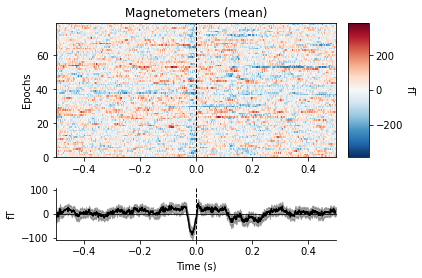

Figure(432x288)


/Users/jenya/opt/anaconda3/envs/mne_new/lib/python3.9/site-packages/mpld3/mplexporter/exporter.py:84: UserWarning:

Blended transforms not yet supported. Zoom behavior may not work as expected.



In [10]:
#THIS FUNCTION CREATES EPOCHS ON BASE OF ECG EVENTS. 
# It calls find_ecg_events internally, so no need to run previous cell for it.

%matplotlib inline

m_or_g = 'mags'
ecg_epochs = mne.preprocessing.create_ecg_epochs(raw_cropped)
f=ecg_epochs.plot_image(combine='mean', picks=m_or_g[0:-1])[0]
print(f)

import mpld3
mpld3.save_html(f,'myfig.html')

Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


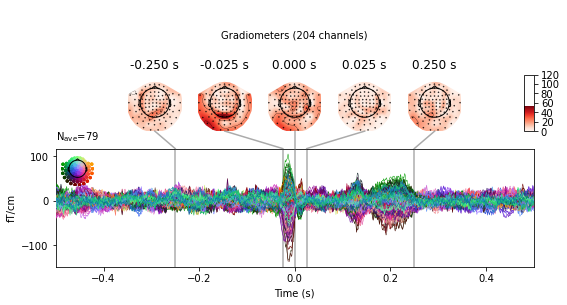

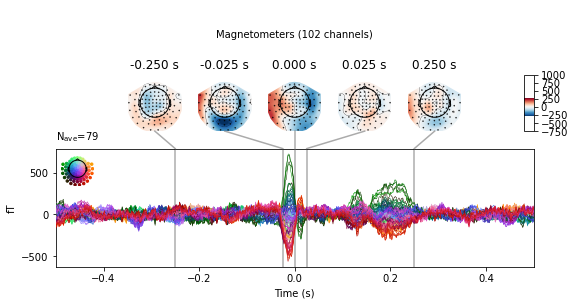

[<Figure size 576x302.4 with 9 Axes>, <Figure size 576x302.4 with 9 Axes>]

In [11]:
# Here I simply repeat the steps from mne tutorial:
# https://mne.tools/stable/auto_tutorials/preprocessing/10_preprocessing_overview.html#sphx-glr-auto-tutorials-preprocessing-10-preprocessing-overview-py

#averaging the ECG epochs together:
avg_ecg_epochs = ecg_epochs.average().apply_baseline((-0.5, -0.2))

avg_ecg_epochs.plot_joint(times=[-0.25, -0.025, 0, 0.025, 0.25])
# I guess 0 represents the actual ECG event and all around - the epoch and how the ECG signal developes during 
# the ECG epoch on everage over all channels?


In [12]:
# How to do correlations of the shape of mean ecg with the data. To see which channels are contaminated most.
# Jochem describedd in the meeting:
# - average epochs around ECG events channel wise -> vector 
# - divide vector by norm (square root of dot product of vector with itself) --> vector of length 1 (reference heartbeat vector)
# - dot product between epoch and norm vector
# (look up in the Statistical Learning course again)


# - 1. average epochs around ECG events channel wise -> vector 
ecg_evoked = mne.preprocessing.create_ecg_epochs(raw_cropped).average()
#print(ecg_evoked.data[0, :]) # for example: averaged ECG event (evoked) data of first channel, all timepoints

#This is the mean epoch over all channels, all ecg epochs: is that the right idea?
ecg_event_mean_overall=np.mean(avg_ecg_epochs.data, axis=0)

import plotly.express as px
fig = px.line(ecg_event_mean_overall)
fig.show()

# Project vector of average ECG artifact onto epoch vector:
# - divide vector by norm (square root of dot product of vector with itself) --> vector of length 1 (reference heartbeat vector)
# - dot product between epoch and norm vector
#  
y_noise=ecg_event_mean_overall

# So project now this average vector onto each of the channels data?




Using channel ECG062 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Number of ECG events detected : 80 (average pulse 79 / min.)
Not setting metadata
80 matching events found
No baseline correction applied
Using data from preloaded Raw for 80 events and 1001 original time points ...
1 bad epochs dropped


In [36]:
# projecting the data now onto the noise vector

#y_noise_norm = np.sqrt(sum(y_noise**2))  

from numpy.linalg import norm
y_noise_norm = norm(y_noise)


proj_of_x_on_y_all=[]
cos_x_y_all = []
for x_data_with_noise in data_mags:
    proj_of_x_on_y = (np.dot(x_data_with_noise, y_noise_norm)/y_noise_norm**2)*y_noise_norm
    proj_of_x_on_y_all += [np.mean(proj_of_x_on_y)]

    #x_data_with_noise_norm = np.sqrt(sum(x_data_with_noise))  
    x_data_with_noise_norm = norm(x_data_with_noise)


    cos_x_y=np.dot(x_data_with_noise, y_noise_norm)/np.dot(x_data_with_noise_norm, y_noise_norm)
    cos_x_y_all += [cos_x_y]


cos_x_y_all

print(proj_of_x_on_y_all)

fig = px.line(proj_of_x_on_y_all)
fig.show()



[-6.5568440027814505e-15, 1.1608865314766343e-16, -3.61771250890687e-15, 2.8416122874553326e-16, -7.867391588967894e-15, -7.59493003289533e-15, -6.728575193680879e-15, -3.5518047915320256e-15, 1.7762314079334193e-15, 1.0350722786604387e-16, 3.033268455212891e-15, -2.799011792019556e-15, -3.3484489511014967e-15, 9.392244540516151e-16, 1.2209470446123323e-14, 4.541604995957348e-15, 1.940171590708665e-15, 5.268656083491944e-15, 5.238702815771268e-15, 2.9682030089866074e-15, 5.9729000475819296e-15, 4.969399776505806e-17, 1.8489562574169233e-15, 4.522956586308755e-15, 9.822013394069047e-15, 1.5064651195362495e-14, 1.9208967418933303e-14, 1.7820601874911906e-14, 9.493777695377757e-15, 8.235174550181431e-15, 1.0173516833239316e-14, 5.6054197775624075e-15, 4.91123042530836e-16, 7.108926419689339e-15, 5.3685310170298215e-15, -9.977622988765564e-16, -1.0644359565771223e-14, -1.0403891152857255e-15, -5.961858399243772e-15, -1.1782281047962894e-14, 4.908374599695273e-15, 1.7756286576427307e-14, -2

In [44]:
import math

def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))

def length(v):
  return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
  return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))


ang_all=[]
for x_data_with_noise in data_mags:
    ang_all.append(np.degrees(angle(y_noise, x_data_with_noise)))

fig = px.line(ang_all)
fig.show()

In [20]:
fig = px.line(proj_of_x_on_y_all[77])
fig.show()


In [ ]:


# General VECTOR PROJECTION technique: https://www.geeksforgeeks.org/vector-projection-using-python/

# finding norm of the vector v
v_norm = np.sqrt(sum(v**2))    
  
# Apply the formula as mentioned above
# for projecting a vector onto another vector
# find dot product using np.dot()
proj_of_u_on_v = (np.dot(u, v)/v_norm**2)*v

# But according to Jochems paper, need to project epoch (data+ noise) onto the noise (ecg_evoked), not the other way around? 
# To find the noise component in the epoch.


# _____________

# Actually, found mne.preprocessing.compute_proj_ecg which seemst to be already doing all the described steps. Is this what we need?
#
# "Compute SSP (signal-space projection) vectors for ECG artifacts.

# This function will:

# Filter the ECG data channel.

# Find ECG R wave peaks using mne.preprocessing.find_ecg_events().

# Filter the raw data.

# Create Epochs around the R wave peaks, capturing the heartbeats.

# Optionally average the Epochs to produce an Evoked if average=True was passed (default).

# Calculate SSP projection vectors on that data to capture the artifacts.

# Evoked objects typically store EEG or MEG signals that have been averaged over multiple epochs,

# 

# _______
# Evoked: shape (n_channels, n_times)
# Epoch: shape (n_epochs, n_channels, n_times)


In [ ]:
df_m = epochs_mags[3].to_data_frame()

df_m

In [ ]:
# Find EOG events:
# https://mne.tools/stable/generated/mne.preprocessing.find_eog_events.html

eog_events=mne.preprocessing.find_eog_events(raw, thresh=None, ch_name=None)
# threshfloat | None
# Threshold to trigger the detection of an EOG event. This controls the thresholding of the underlying 
# peak-finding algorithm. Larger values mean that fewer peaks (i.e., fewer EOG events) will be detected. 
# If None, use the default of (max(eog) - min(eog)) / 4, with eog being the filtered EOG signal.

# UNLIKE ECG, CAN NOT RECONSTRUCT EOG EVENTS IF NO DEDICATED CHANNEL IS PRESENT. SO EPOCHS CANT BE CREATED EITHER
# AS EOG channels it needs either: with type eog or ordinary EEG channel that was placed close to the eyes, like Fp1 or Fp2

# But we dont have any of these

# Another related function, but again needs EOG channel or other channels where EOG should be extracted from:
# https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA.find_bads_eog

eog_events_times  = (eog_events[:, 0] - raw.first_samp) / raw.info['sfreq']


In [ ]:
# RUN THIS CELL ONLY IF YOU DONT HAVE EOG CHANNELS

# "If you don’t have an EOG channel, find_bads_eog has a ch_name parameter that you can use as a proxy for EOG. 
# You can use a single channel, or create a bipolar reference from frontal EEG sensors and use that as virtual EOG channel. 
# This carries a risk however: you must hope that the frontal EEG channels only reflect EOG and not brain dynamics in 
# the prefrontal cortex (or you must not care about those prefrontal signals)."

# So here I plot the magnetometers layout, choose 4 magnetometers near the eyes and try to extract eyeblinks from there

# What is better mags or grads for eyeblinks reconstruction? Or both?

%matplotlib inline

layout_from_raw=mne.channels.find_layout(raw.info, ch_type='mag')
fig=layout_from_raw.plot()

eog_events=mne.preprocessing.find_eog_events(raw, thresh=1e-8, ch_name=['MEG0521', 'MEG0911', 'MEG0511', 'MEG0921'])
# Threshold to trigger the detection of an EOG event. This controls the thresholding of the underlying peak-finding algorithm. 
# Larger values mean that fewer peaks (i.e., fewer EOG events) will be detected. 
# If None, use the default of (max(eog) - min(eog)) / 4, with eog being the filtered EOG signal.

# Detected only 3 EOG events in th entire 1h dataset if threshold is set to defailt: thresh=None
# -> Try to adjust threshold or, maybe it just doesnt really work.
# -> Above: set the threshold to 1e-8, detects 17 eyeblink events - also too little. But I got no idea what threshold value is optimal.

#%% Now want to see the data for these 4 channels I chose for eyeblinks:
chans = ['MEG0521', 'MEG0911', 'MEG0511', 'MEG0921']

#I only know how to plot channels by the idexes, not by names, so have to extract indexes first:
EOG_ch=[]
for c in chans:
    ch=[item for item in mags if c in item]
    EOG_ch.append(ch[0][1])

%matplotlib qt
raw.plot(order=EOG_ch, start=12, duration=4) #plot here only a part of channel."

#Lets discuss if these look like eyeblink!

In [ ]:
# Extract EOG epochs:

eog_epochs = mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.2))
#eog_epochs = mne.preprocessing.create_eog_epochs(raw)
#This function will internally call the find_eog_events again (no need to run previous cell). 


eog_epochs.plot_image(combine='mean')
eog_epochs.average().plot_joint()

#Looks not the same as in preprocessing tutorial:
# https://mne.tools/stable/auto_tutorials/preprocessing/10_preprocessing_overview.html#sphx-glr-auto-tutorials-preprocessing-10-preprocessing-overview-py

#Claims that it found EOG evemts but they dont really look like any events.

In [ ]:
# Next, there is ICA used for ECG and EOG artifacts repair.
# https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html

# Functions ica_find_ecg_events and ica_find_eog_events - are not working independently, 
# they need to functions above to run first





In [ ]:
# found interesting function to fix stimulus artifacts: 
# https://mne.tools/stable/generated/mne.preprocessing.fix_stim_artifact.html